Caso precise instalar algum dos pacotes do python em uma célula do collab, use o seguinte comando:
- !pip install seu-pacote

In [396]:
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Imports para análise e limpeza dos dados

In [397]:
import pathlib
import pandas           as pd
import numpy            as np
import matplotlib.pylab as plt
import plotly.express   as px
import seaborn          as sns
from collections import Counter

## Imports para Machine Learning

In [447]:
# Pré-processamento e divisão para treino e testes
from sklearn                 import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Algoritmos para seleção do melhor modelo de ML
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Métricas para validação de cada modelo
from sklearn.metrics         import confusion_matrix, accuracy_score, mean_absolute_error, roc_curve, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from pycaret.classification import *

In [276]:
## Caminho para os arquivos

path = pathlib.Path().cwd() / 'files/bs140513_032310.csv'

In [277]:
## importando arquivos e fazendo o reconhecimento dos dados

fraud_df = pd.read_csv(path)
fraud_df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


### Dimensões do Dataset Original:

- 594643 linhas
- 9 colunas

### Características relevantes do dataset

Alguns dados estão transformados:
- Os passos se referem à datas, entre os anos de 2012 a 2013. Entretanto, não foram descritas as datas exatas para esse intervalo. De certo, os dados correspondem a transações de 6 meses.
- A idade também foi pré-processada, com as seguintes características:

    - 0 = <18 anos
    - 1 = 19-25 anos
    - 2 = 26-35 anos
    - 3 = 36-45 anos
    - 4 = 46-55 anos
    - 5 = 56-65 anos
    - 6 = >65 anos
    - U = desconhecido

### Análise Exploratória dos dados

Analisando características do dataset

In [278]:
fraud_df.describe()

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


In [279]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [280]:
fraud_df.columns

Index(['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant',
       'zipMerchant', 'category', 'amount', 'fraud'],
      dtype='object')

In [281]:
## Avaliando as variáveis de texto para compreender se há colunas com dados únicos, não sendo úteis para a montagem do modelo
fraud_df_text = fraud_df[['age', 'customer', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant', 'category']]

for i in fraud_df_text.columns:
    print(f'A quantidade de dados únicos para a coluna {i} é: {fraud_df_text[i].nunique()}')


A quantidade de dados únicos para a coluna age é: 8
A quantidade de dados únicos para a coluna customer é: 4112
A quantidade de dados únicos para a coluna gender é: 4
A quantidade de dados únicos para a coluna zipcodeOri é: 1
A quantidade de dados únicos para a coluna merchant é: 50
A quantidade de dados únicos para a coluna zipMerchant é: 1
A quantidade de dados únicos para a coluna category é: 15


In [282]:
# Eliminando os dados de zipcode, pois serão irrelevantes para nossa análise.

fraud_df = fraud_df.drop(['zipcodeOri', 'zipMerchant'], axis=1)
fraud_df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151','4','M','M348934600','es_transportation',4.55,0
1,0,'C352968107','2','M','M348934600','es_transportation',39.68,0
2,0,'C2054744914','4','F','M1823072687','es_transportation',26.89,0
3,0,'C1760612790','3','M','M348934600','es_transportation',17.25,0
4,0,'C757503768','5','M','M348934600','es_transportation',35.72,0


### Evidências na análise exploratória

É importante citar que:
- Os dados apresentados não possuem linhas nulas, um bom indicativo para que possamos usar o dataset sem implicar em uma limpeza maior dos dados.
- Há duas colunas que poderão ser desconsidaradas, já que aprensentam 1 único valor, que não é útil para o modelo de aprendizado de máquina: zipcodeOri e zipMerchant. Entretanto, para o caso de haver uma maior diversificação de região, é interessante ler o conteúdo e considerar a coluna como uma feature.

# Análise Bivariada

## Verificando o comportamento geral dos casos de compras, comparando tipos de compra x idade

Analisando a disperção dos valores de acordo com a faixa de idade dos compradores.

A ordem aqui segue o padrão anterior, inicialmente os casos gerais, e depois apenas os casos de fraude.

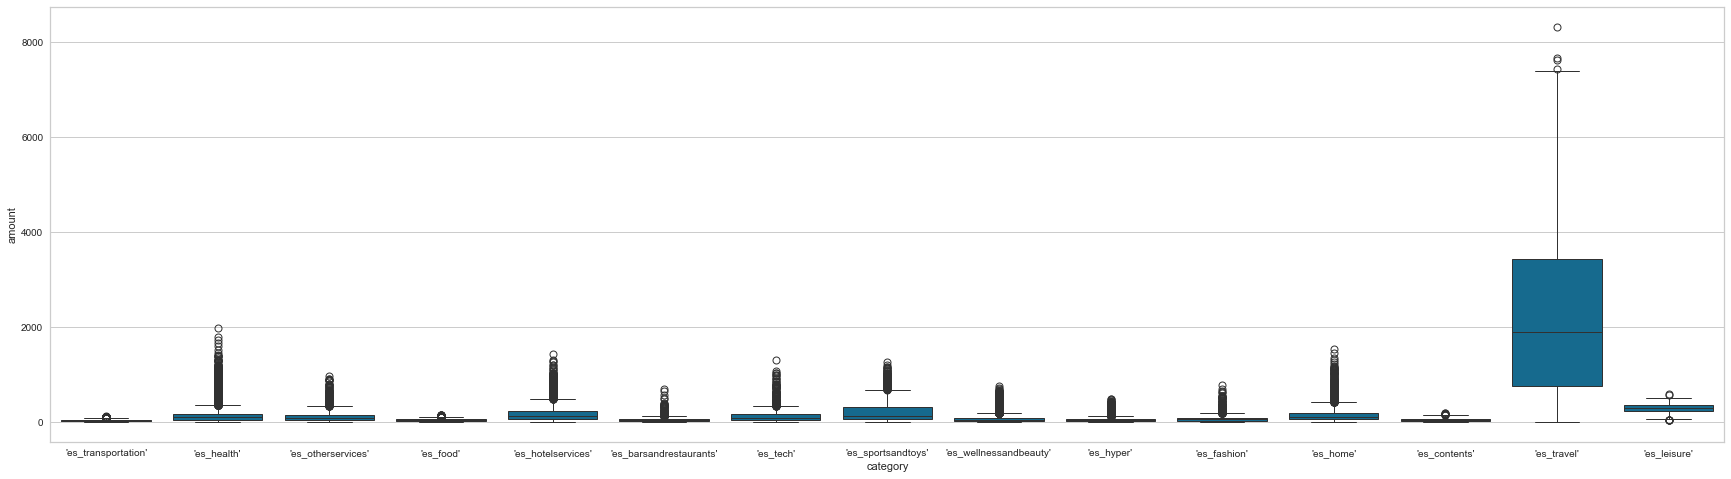

In [283]:
# Analisando as compras realizadas por cada categoria.

plt.subplots(figsize=(30,8))
sns.boxplot(data=fraud_df, x='category', y='amount')
plt.show()

Quantidade de casos de fraude: 7200


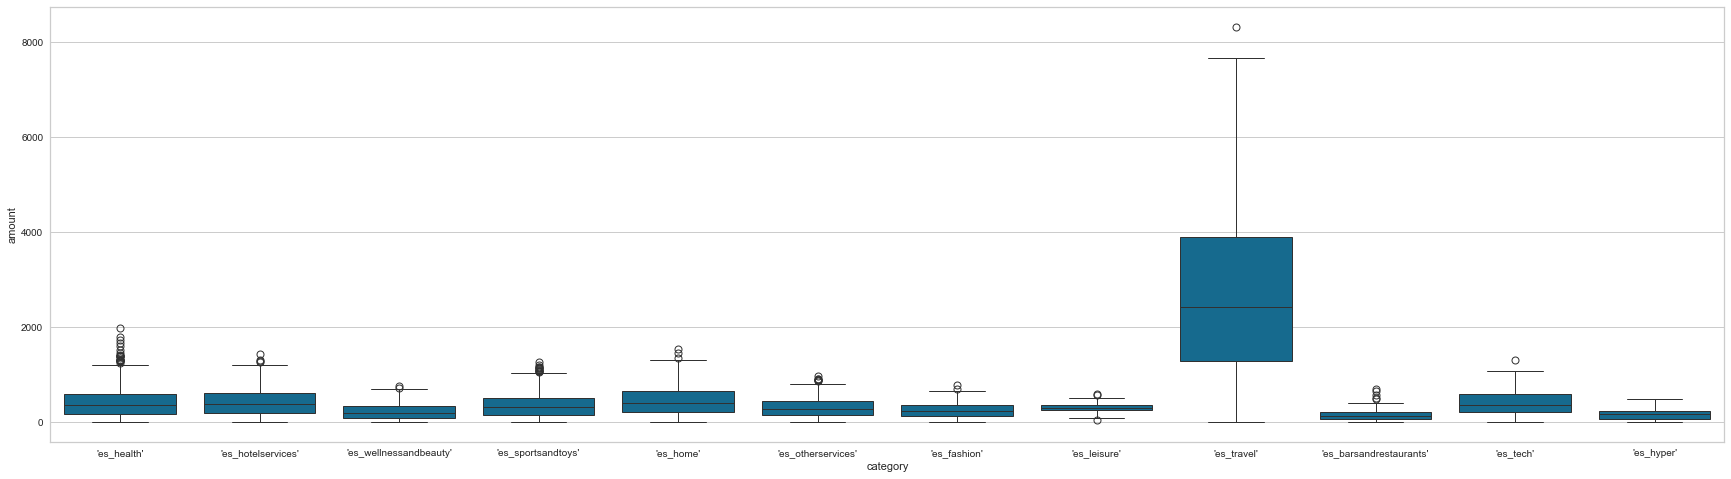

In [284]:
# Analisando as compras realizadas por cada categoria, agora verificando os casos onde houveram fraudes

cases = fraud_df.loc[fraud_df['fraud'] == 1].shape[0]
print(f'Quantidade de casos de fraude: {cases}')

plt.subplots(figsize=(30,8))
sns.boxplot(data=fraud_df.loc[fraud_df['fraud'] == 1], x='category', y='amount')
plt.show()

## Verificando o comportamento geral dos casos de compras, comparando valor x idade

Analisando a disperção dos valores de acordo com a faixa de idade dos compradores.

A ordem aqui segue o padrão anterior, inicialmente os casos gerais, e depois apenas os casos de fraude.

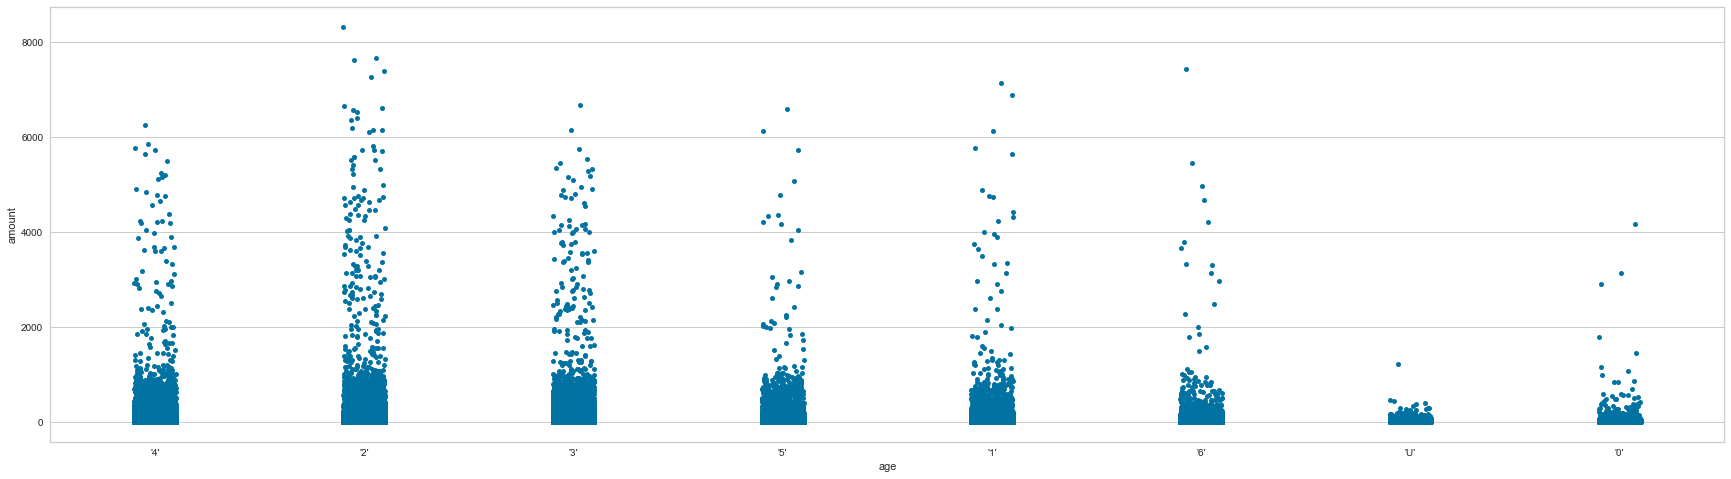

In [285]:
# Verificando o comportamento geral dos casos de compras, comparando valor x idade

order = ['0', '1', '2', '3', '4', '5', '6', 'U']

plt.subplots(figsize=(30,8))
sns.stripplot(data=fraud_df, x='age', y='amount')
plt.show()

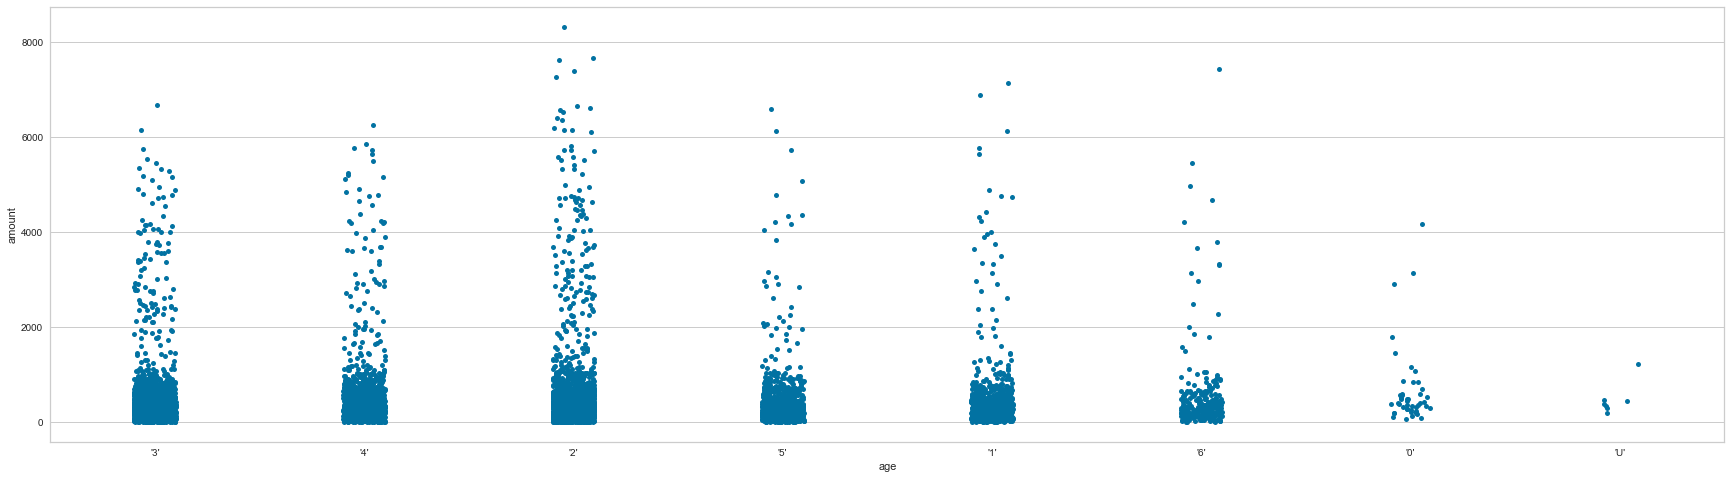

In [286]:
# Verificando o comportamento geral dos casos de compras, comparando valor x idade

cases = fraud_df.loc[fraud_df['fraud'] == 1]

plt.subplots(figsize=(30,8))
sns.stripplot(data=cases, x='age', y='amount')
plt.show()

Analisando os gráficos acima, obtemos uma visão geral de como as compras se distribuem enquanto analisamos casos compravados de fraude e transações legítimas.

Também é interessante notar como há um descolamento de valores, mas ainda assim uma boa quantidade de compras acima de 2000.

In [287]:
# Verificando os maiores casos de fraude
cases['category'].value_counts()

'es_sportsandtoys'         1982
'es_health'                1696
'es_wellnessandbeauty'      718
'es_travel'                 578
'es_hotelservices'          548
'es_leisure'                474
'es_home'                   302
'es_hyper'                  280
'es_otherservices'          228
'es_tech'                   158
'es_barsandrestaurants'     120
'es_fashion'                116
Name: category, dtype: int64

In [288]:
cases['age'].value_counts()

'2'    2344
'3'    1755
'4'    1410
'1'     689
'5'     686
'6'     261
'0'      48
'U'       7
Name: age, dtype: int64

In [289]:
# Agora verificando casos que não foram capturados como fraude
not_cases = fraud_df.loc[fraud_df['fraud'] == 0]
not_cases['category'].value_counts()

'es_transportation'        505119
'es_food'                   26254
'es_health'                 14437
'es_wellnessandbeauty'      14368
'es_fashion'                 6338
'es_barsandrestaurants'      6253
'es_hyper'                   5818
'es_tech'                    2212
'es_sportsandtoys'           2020
'es_home'                    1684
'es_hotelservices'           1196
'es_contents'                 885
'es_otherservices'            684
'es_travel'                   150
'es_leisure'                   25
Name: category, dtype: int64

In [290]:
not_cases['age'].value_counts()

'2'    184966
'3'    145376
'4'    107615
'5'     61956
'1'     57442
'6'     26513
'0'      2404
'U'      1171
Name: age, dtype: int64

In [291]:
not_cases["amount"].value_counts().sort_values()

190.31      1
180.26      1
134.47      1
258.55      1
106.26      1
         ... 
17.26     143
16.12     143
17.57     144
14.93     146
26.67     146
Name: amount, Length: 18809, dtype: int64

### Anotações

Podemos notar que:
- Casos de fraude são mais comuns para o setor de brinquedos e esportes, dentro da faixa 2 de idade.
- Ainda assim, a faixa 2 também é responsável por boa parte das compras que não foram marcadas como fraude, embora haja uma mudança na categoria que mais registra casos "normais": transporte


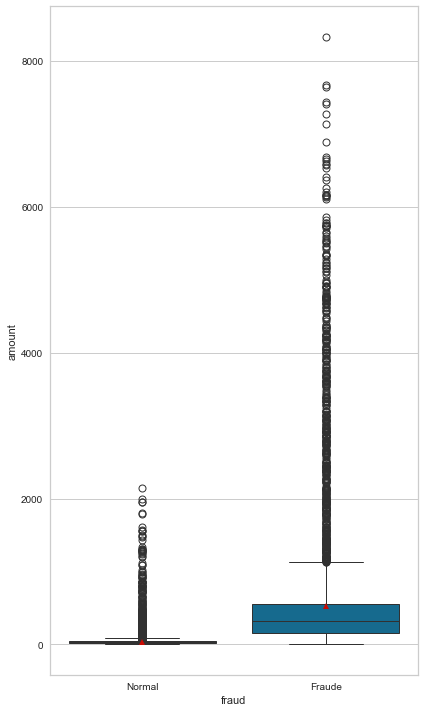

In [443]:
fig, ax = plt.subplots(figsize=(6, 10), sharex=True)

sns.boxplot(x='fraud', y='amount', data=fraud_df, showmeans=True, ax=ax)
# plt.ylim((-20, 400))
plt.xticks([0, 1], ['Normal', 'Fraude'])

plt.tight_layout()
plt.show()

Aqui, podemos ver a conversão de informações entre casos de fraude e casos "normais", ou não fraudulentos.

Vemos que há uma certa tendência de casos fraudulentos de tentarem obter grandes quantias, dada pelas repostas na coluna amount.

Assim é interessante não remover dados como "outliers" nesse momento, para verificarmos um maior range de informações

In [292]:
# # removendo outliers

# def remove_outliers(df, column):
#     # Calcular o primeiro e terceiro quartil
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
    
#     # Calcular o Intervalo Interquartil (IQR)
#     IQR = Q3 - Q1
    
#     # Definir os limites inferior e superior
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     # Filtrar o dataframe para remover outliers
#     filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
#     return filtered_df

# filtered_df = remove_outliers(fraud_df, 'amount')
# filtered_df

In [293]:
# # Analisando as compras realizadas por cada categoria.

# plt.subplots(figsize=(30,8))
# sns.boxplot(data=filtered_df, x='category', y='amount')
# plt.show()

In [294]:
# # Analisando as compras realizadas por cada categoria, agora verificando os casos onde houveram fraudes

# cases = filtered_df.loc[filtered_df['fraud'] == 1].shape[0]
# print(f'Quantidade de casos de fraude: {cases}')

# plt.subplots(figsize=(30,8))
# sns.boxplot(data=filtered_df.loc[filtered_df['fraud'] == 1], x='category', y='amount')
# plt.show()

In [295]:
# # Verificando o comportamento geral dos casos de compras, comparando valor x idade

# order = ['0', '1', '2', '3', '4', '5', '6', 'U']

# plt.subplots(figsize=(30,8))
# sns.stripplot(data=filtered_df, x='age', y='amount')
# plt.show()

In [296]:
# # Verificando o comportamento geral dos casos de compras, comparando valor x idade

# cases = filtered_df.loc[filtered_df['fraud'] == 1]

# plt.subplots(figsize=(30,8))
# sns.stripplot(data=cases, x='age', y='amount')
# plt.show()

# Pré-processamento dos dados

Aqui nos iremos fazer o trabalho de transformar os dados em um formato que possa ser compreendido pelo modelo de Machine Learning.
- Inicialmente, iremos transformar os dados de amount em categorias que possam ser convertidas em números para nosso modelo.
- Em seguida iremos converter todas as categorias de texto para número, utilizando 2 métodos: Label enconder e One hot encoder.
    - O primeiro método será aplicado em categorias que irão se encaixar melhor com a codificação de label.
    - O segundo método irá lidar melhor com a variabilidade nas colunas gender e category.
- Também iremos realizar a exclusão de colunas que não irão contribuir com o processamento do dataset pelo modelo de machine learning.
- Depois iremos criar um balanceamento dos dados, igualando a quantidade de dados de fraude e casos que passaram como não-fraude.
- Por fim, iremos separar nossos dados entre dados de treino e teste, e realizar a normalização dos dados, para melhorar a efetividade dos modelos a serem testados.

In [416]:
process_df = fraud_df
fraud_df.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud', 'amount_category'],
      dtype='object')

Dado que o modelo de machine learning deve ser treinado com dados númericos, iremos iniciar a transformação dos dados de texto para numéricos.

No caso dos dados de amount, a ideia é criar um intervalo para que possamos detectar, além do valor, qual intervalo aquela transação pode se envolver em uma fraude.

In [417]:
## Passo 1

# Definindo novos intervalos (bins) para rebalancear a distribuição
bins = [0, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 2000, 4000, 6000, 8000, 8400]
labels = ['0-20', '20-40', '40-60', '60-80', '80-100', '100-200', '200-400', '400-600', '600-800', '800-1000', '1000-2000', '2000-4000', '4000-6000', '6000-8000', '8000-8400']

# Criando uma nova coluna categorizada
process_df['amount_category'] = pd.cut(process_df['amount'], bins=bins, labels=labels, include_lowest=True)

# print(process_df['amount_category'].value_counts())

Esta etapa de preprocessing irá facilitar a conversão dos dados de texto. Aqui se envolvem os métodos:
- Label Encoder: iremos usar para dados que possam ser ordenados. Isso não terá importância para customer e merchant, e será útil para a categoria do amount.
- One Hot Encoder: nos dará liberdade no pré-processamento de dados não ordenados.

In [418]:
## Passo 2

# Aqui estamos convertendo textos para registros numéricos, permitindo que o algoritmo de machine learning leia as colunas
label_encoder = preprocessing.LabelEncoder()
one_hot_encoder_gender = preprocessing.OneHotEncoder(sparse_output=False)
one_hot_encoder_category = preprocessing.OneHotEncoder(sparse_output=False)

# columns_1 = ['customer', 'merchant', 'amount_category', 'zipcodeOri', 'zipMerchant']
columns_1 = ['customer', 'merchant', 'amount_category']
columns_2 = ['gender', 'category']

# Pré-processamento final dos dados
fraud_ml = process_df.copy()
fraud_ml.replace("'", "", regex=True, inplace=True)
fraud_ml['age'].replace("U", "7", inplace=True)
fraud_ml['age'] = fraud_ml['age'].astype(int)

for i in columns_1:
    fraud_ml[i] = label_encoder.fit_transform(fraud_ml[i])

# Ajustando e transformando o OneHotEncoder no mesmo conjunto de dados
fraud_ml_gender = one_hot_encoder_gender.fit_transform(fraud_ml[['gender']])
fraud_ml_category = one_hot_encoder_category.fit_transform(fraud_ml[['category']])

# Obtendo os nomes das colunas corretamente
df_gender_encoded = pd.DataFrame(fraud_ml_gender, columns=one_hot_encoder_gender.get_feature_names_out(['gender']))
df_category_encoded = pd.DataFrame(fraud_ml_category, columns=one_hot_encoder_category.get_feature_names_out(['category']))

# Concatenando os resultados
fraud_ml = pd.concat([fraud_ml, df_gender_encoded, df_category_encoded], axis=1)
fraud_ml = pd.concat([fraud_ml, df_category_encoded], axis=1)

In [419]:
fraud_ml = fraud_ml.copy().dropna(axis=0)
fraud_ml.head()

,step,customer,age,gender,merchant,category,amount,fraud,amount_category,gender_0,...,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty
0,0,210,4,2,30,es_transportation,4.55,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,2753,2,2,30,es_transportation,39.68,0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,2285,4,1,18,es_transportation,26.89,0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,1650,3,2,30,es_transportation,17.25,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,3585,5,2,30,es_transportation,35.72,0,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [444]:
# ## Correlação inicial dos dados. Este passo não deve ser incluído como passo de análise do modelo, e sim para verificação de correlação de colunas apenas. Pode ser ignorado no trabalho final

# # Calculando a matriz de correlação
# correlation_matrix = fraud_ml.corr()

# # Criando um mapa de calor
# plt.figure(figsize=(20,20))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
# plt.title('Mapa de Calor da Correlação')
# plt.show()

Aqui estamos simplesmente eliminando 3 colunas que não possuem mais uso dentro do nosso dataset que servirá de base para o treino do modelo.

In [421]:
## Passo 3

# Removendo últimas colunas para montar o dataset que irá para treino
fraud_ml.drop(['step', 'gender', 'category'], axis=1, inplace=True)

Verificar a distribuição das classes nos dá uma visão de como ficará nosso dataset:

In [422]:
# Supondo que você tenha um DataFrame chamado df com suas características (features) e a variável alvo (target)
# Substitua 'x' com suas características e 'y' com sua variável alvo
x = fraud_ml.drop('fraud', axis=1)
y = fraud_ml['fraud']

# Mostra a distribuição original das classes
print(f'Distribuição original das classes: {Counter(y)}')

Distribuição original das classes: Counter({0: 587443, 1: 7200})


No próximo passo, iremos diminuir o número de dados que estão na maior classe, de forma a deixar o modelo menos propenso a olhar e prever a classe de maior valor

Isso se dá pois há um desbalanceamento de dados, o que pode deixar nosso modelo muito bom em apenas 1 classe

In [445]:
## Passo 4

# Cria o objeto RandomUnderSampler
rus = NearMiss()
X_resampled, y_resampled = rus.fit_resample(x, y)

# Este trecho comentado pode ser utilizado para avaliar nosso modelo com oversampling. Por hora, o melhor nos testes é o undersampling, já habilitado aqui
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(x, y)

# Mostra a nova distribuição das classes
print(f'Nova distribuição das classes: {Counter(y_resampled)}')


Nova distribuição das classes: Counter({0: 7200, 1: 7200})


In [446]:
# Converte de volta para DataFrame se necessário
df_resampled = pd.DataFrame(X_resampled, columns=x.columns)
df_resampled['fraud'] = y_resampled

# df_resampled.head()
fraud_ml = df_resampled
fraud_ml.head()

,customer,age,merchant,amount,amount_category,gender_0,gender_1,gender_2,gender_3,category_es_barsandrestaurants,...,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,1838,4,36,30.57,3,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,615,5,43,57.20,6,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,769,5,9,0.67,0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,4098,4,15,70.53,9,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,769,5,30,26.17,3,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


Aqui iremos separar os dados alvo (y) do resto do dataset(x) e separar os dados de treino e teste do modelo de machine learning

In [425]:
## Passo 5

x = fraud_ml.drop(columns=['fraud'])
y = fraud_ml['fraud']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state = 42, stratify=y, shuffle=True)

Normalização, o passo abaixo, promoverá a possibilidade do modelo ter dados padronizados entre 0 e 1, obtendo contribuição de mais colunas dentro do treinamento

In [426]:
## Passo 5

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Montagem do pipeline para criação do algoritmo

Aqui, iremos iniciar o treinamento de nosso modelo.
Nosso problema atual tem como premissa um resultado binário (0 ou 1, fraude ou não fraudulento), e que será avaliado a partir de 2 modelos: Random Forest Classifier e Logistic Regression

Nós iremos fazer uma leve varredura nos melhores parâmetros para ambos os modelos e, em seguida, realizar seu treinamento a partir dos hiperparâmetros selecionados.
Note que esse treinamento será feito de forma simples no momento atual.

Em seguida, iremos fazer a análise por meio de 2 métodos:
- Análise pela Curva ROC
- Matriz de confusão, analisando as taxas de:
    - TP = true positive (verdadeiros positivos): casos reais de fraude
    - FP = false positive (falsos positivos): casos marcados como fraude, mas que não são
    - FN = false negative (verdadeiros negativos): casos marcados como não fraudulentos, mas são casos de fraude
    - TN = true negative (falsos negativos): casos não fraudulentos

## Random Forest Classifier

In [451]:
# Definindo o modelo
rf = RandomForestClassifier(random_state=42)

# Definindo a grade de parâmetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configurando o GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Ajustando o modelo
grid_search.fit(x_train, y_train)

# Melhor combinação de hiperparâmetros
best_params = grid_search.best_params_
print(f"Melhores hiperparâmetros: {best_params}")

# Avaliando o modelo com os melhores hiperparâmetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia com os melhores hiperparâmetros: {accuracy}")

Melhores hiperparâmetros: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Acurácia com os melhores hiperparâmetros: 0.9696759259259259


In [452]:
# Random Forest Classifier
rf = RandomForestClassifier(bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200, class_weight='balanced', random_state=42) 
model = rf.fit(x_train, y_train)

y_pred = model.predict(x_test)
# accuracy_score(y_test, y_pred)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {roc_auc}")

Acurácia: 0.9696759259259259
Precisão: 0.9588421528720036
Recall: 0.9814814814814815
F1-Score: 0.9700297414779226
AUC-ROC: 0.9696759259259259


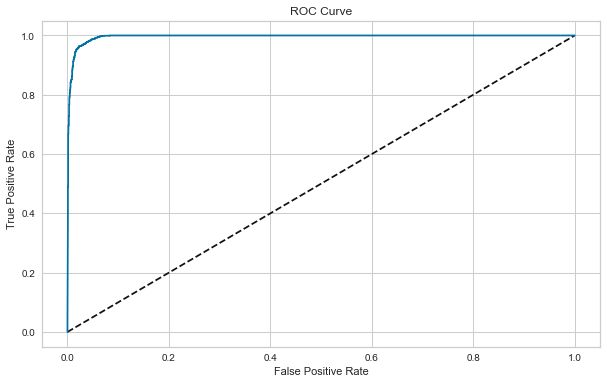

In [453]:
y_pred_prob = model.predict_proba(x_test)[:,1]

# Gera fpr, tpr e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# curva ROC
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Relatório de classificação:
              precision    recall  f1-score   support

           0     0.9810    0.9579    0.9693      2160
           1     0.9588    0.9815    0.9700      2160

    accuracy                         0.9697      4320
   macro avg     0.9699    0.9697    0.9697      4320
weighted avg     0.9699    0.9697    0.9697      4320

AUC ROC: 0.9697



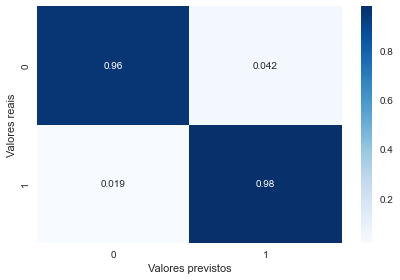

In [454]:
# avaliando o desempenho do modelo treinado com dataset balanceado com random under sampler
print(f'Relatório de classificação:\n{classification_report(y_test, y_pred, digits=4)}')

# avaliando AUC do modelo
print("AUC ROC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# matriz de confusão
fig, ax = plt.subplots()

sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', annot=True, ax=ax)

ax.set_ylabel("Valores reais")
ax.set_xlabel("Valores previstos")

# plt.savefig('results-rus.png')

plt.tight_layout()

## Resultados dos testes com Random Forest

Como é possível ver, por meio da matriz de confusão vemos uma alta precisão para a verificação de casos de verdadeiros positivos (TP=98%) em relação ao valor real.

Ainda assim, os casos negativos (TN=96%) mostraram cerca de 4 em cada 100 casos erroneamente como casos fraudulentos.

In [431]:
## Teste, pular para a próxima célula

# # Listas para armazenar os resultados
# train_errors = []
# test_errors = []
# max_depths = range(1,10)

# # Treinando e avaliando o modelo para diferentes valores de max_depth
# for max_depth in max_depths:
#     model_train = RandomForestClassifier(max_depth=max_depth, min_samples_split=6, n_estimators=50, random_state=42)
#     model_train.fit(x_train, y_train)
    
#     # Previsões no conjunto de treino e teste
#     y_train_pred = model_train.predict(x_train)
#     y_test_pred = model_train.predict(x_test)
    
#     # Calculando o MAE
#     train_mae = mean_absolute_error(y_train, y_train_pred)
#     test_mae = mean_absolute_error(y_test, y_test_pred)
    
#     # Armazenando os resultados
#     train_errors.append(train_mae)
#     test_errors.append(test_mae)

# # Plotando os resultados
# plt.figure(figsize=(10, 6))
# plt.plot(max_depths, train_errors, label='Train MAE', marker='o')
# plt.plot(max_depths, test_errors, label='Test MAE', marker='o')
# plt.xlabel('max_depth')
# plt.ylabel('Mean Absolute Error')
# plt.title('MAE vs max_depth for RandomForestClassifier')
# plt.legend()
# plt.grid(True)
# plt.show()

In [432]:
# Definindo o modelo
lr = LogisticRegression()

# Definindo a grade de parâmetros
param_grid = {
    'C': [0.01, 0.1, 1, 10, 25, 50, 100, 200],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag']
}

# Configurando o GridSearchCV
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Ajustando o modelo
grid_search.fit(x_train, y_train)

# Melhor combinação de hiperparâmetros
best_params = grid_search.best_params_
print(f"Melhores hiperparâmetros: {best_params}")

# Avaliando o modelo com os melhores hiperparâmetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia com os melhores hiperparâmetros: {accuracy}")


Melhores hiperparâmetros: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Acurácia com os melhores hiperparâmetros: 0.9618055555555556


In [455]:
# Testando agora com logistic regression
lr = LogisticRegression(C=10, penalty='l1', solver='liblinear')
model_2 = lr.fit(x_train, y_train)

y_pred = model_2.predict(x_test)
# accuracy_score(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {roc_auc}")

Acurácia: 0.9618055555555556
Precisão: 0.9423503325942351
Recall: 0.9837962962962963
F1-Score: 0.9626274065685164
AUC-ROC: 0.9618055555555555


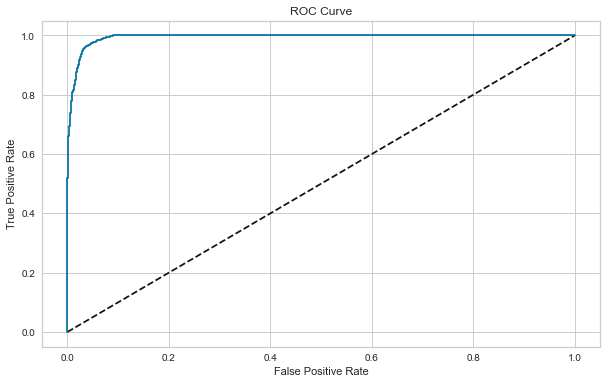

In [456]:
y_pred_prob = model_2.predict_proba(x_test)[:,1]

# Gera fpr, tpr e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# curva ROC
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Relatório de classificação:
              precision    recall  f1-score   support

           0     0.9831    0.9398    0.9609      2160
           1     0.9424    0.9838    0.9626      2160

    accuracy                         0.9618      4320
   macro avg     0.9627    0.9618    0.9618      4320
weighted avg     0.9627    0.9618    0.9618      4320

AUC ROC: 0.9618



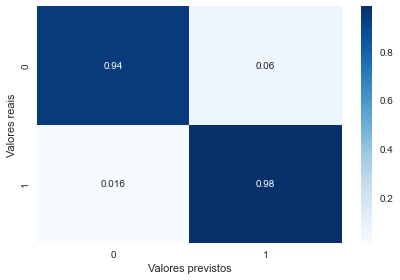

In [457]:
# avaliando o desempenho do modelo treinado com dataset balanceado com random under sampler
print(f'Relatório de classificação:\n{classification_report(y_test, y_pred, digits=4)}')

# avaliando AUC do modelo
print("AUC ROC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# matriz de confusão
fig, ax = plt.subplots()

sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), cmap='Blues', annot=True, ax=ax)

ax.set_ylabel("Valores reais")
ax.set_xlabel("Valores previstos")

# plt.savefig('results-rus.png')

plt.tight_layout()

## Resultados dos testes com logistic regression

O teste para esse modelo obteve uma queda interessante na verificação de casos não fraudulentes, avaliando 2 casos menos que o modelo anterior (de 96% para 94%).

Ainda assim, é interessante notar que houve um empate na questão de casos positivos (98%)

In [480]:
# # Função para gerar valores de amount com maior concentração entre 0 e 100
# def generate_amount():
#     if np.random.rand() < 0.8:  # 80% de chance de estar entre 0 e 100
#         return np.round(np.random.uniform(0.1, 100), 2)
#     else:  # 20% de chance de estar entre 100 e 8400
#         return np.round(np.random.uniform(100, 8400), 2)
    
# label_encoder = preprocessing.LabelEncoder()
# one_hot_encoder_gender = preprocessing.OneHotEncoder(sparse_output=False)
# one_hot_encoder_category = preprocessing.OneHotEncoder(sparse_output=False)

# novo_exemplo = pd.DataFrame({
#     'step': np.random.randint(1, 200, 500),
#     'customer': [f'C{np.random.randint(100000000, 999999999)}' for _ in range(500)],
#     'age': np.random.choice([0, 1, 2, 3, 4, 5, 6, 7], 500),
#     'gender': np.random.choice(['M', 'F', 'E', 'U'], 500),
#     'merchant': [f'M{np.random.randint(100000000, 999999999)}' for _ in range(500)],
#     'category': np.random.choice([
#         "es_transportation", "es_health", "es_otherservices", "es_food",
#         "es_hotelservices", "es_barsandrestaurants", "es_tech",
#         "es_sportsandtoys", "es_wellnessandbeauty", "es_hyper", "es_fashion",
#         "es_home", "es_contents", "es_travel", "es_leisure"
#     ], 500),
#     'amount': [generate_amount() for _ in range(500)],
#     'fraud': np.random.choice([0, 1], 500, p=[0.95, 0.05]),
#     'zipcodeOri': '28007',
#     'zipMerchant': '28007',
# })

# label_columns = ['customer', 'merchant', 'amount_category', 'zipcodeOri', 'zipMerchant']

# columns_order = ['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant',
#        'zipMerchant', 'category', 'amount', 'fraud']

# novo_exemplo = novo_exemplo[columns_order]
# # Definindo os intervalos (bins) e os rótulos (labels)
# bins = [0, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000, 2000, 4000, 6000, 8000, 8400]
# labels = ['0-20', '20-40', '40-60', '60-80', '80-100', '100-200', '200-400', '400-600', '600-800', '800-1000', '1000-2000', '2000-4000', '4000-6000', '6000-8000', '8000-8400']

# # Criando a coluna categorizada
# novo_exemplo['amount_category'] = pd.cut(novo_exemplo['amount'], bins=bins, labels=labels, include_lowest=True)

# # Função para lidar com novos valores no LabelEncoder
# def handle_new_labels(encoder, value):
#     if value in encoder.classes_:
#         return encoder.transform([value])[0]
#     else:
#         # Adiciona a nova classe temporariamente e transforma o valor
#         new_classes = np.append(encoder.classes_, value)
#         encoder.classes_ = new_classes
#         return encoder.transform([value])[0]

# # Aplique o mesmo pré-processamento no novo exemplo
# novo_exemplo['age'].replace("U", "7", inplace=True)
# novo_exemplo['age'] = novo_exemplo['age'].astype(int)

# # Ajuste inicial para garantir que o LabelEncoder tenha classes
# for col in label_columns:
#     label_encoder.fit(novo_exemplo[col])

# # Aplicar LabelEncoder nas colunas categóricas com verificação de novos valores
# for i in label_columns:
#     novo_exemplo[i] = novo_exemplo[i].apply(lambda x: handle_new_labels(label_encoder, x))

# # Aplicar OneHotEncoder nas colunas 'gender' e 'category'
# novo_exemplo_gender = one_hot_encoder_gender.fit_transform(novo_exemplo[['gender']])
# novo_exemplo_category = one_hot_encoder_category.fit_transform(novo_exemplo[['category']])

# # Convertendo os resultados para DataFrame
# df_novo_exemplo_gender = pd.DataFrame(novo_exemplo_gender, columns=one_hot_encoder_gender.get_feature_names_out(['gender']))
# df_novo_exemplo_category = pd.DataFrame(novo_exemplo_category, columns=one_hot_encoder_category.get_feature_names_out(['category']))

# # Concatenando as novas colunas com o novo exemplo
# novo_exemplo = pd.concat([novo_exemplo, df_novo_exemplo_gender, df_novo_exemplo_category], axis=1)

# y = novo_exemplo['fraud']

# # Removendo colunas desnecessárias
# novo_exemplo.drop(['gender', 'category', 'fraud', 'step'], axis=1, inplace=True)

# # Aplicando o mesmo escalonamento de valores
# scaler = MinMaxScaler()
# novo_exemplo_scaled = scaler.fit_transform(novo_exemplo)

ValueError: X has 26 features, but LogisticRegression is expecting 39 features as input.

In [478]:
# # Realizando a previsão
# y_pred_novo_exemplo = model.predict(novo_exemplo_scaled) # Random Forest

# # print(f'Previsão para o novo exemplo: {y_pred_novo_exemplo}')

# accuracy = accuracy_score(y, y_pred_novo_exemplo)
# precision = precision_score(y, y_pred_novo_exemplo)
# recall = recall_score(y, y_pred_novo_exemplo)
# f1 = f1_score(y, y_pred_novo_exemplo)
# roc_auc = roc_auc_score(y, y_pred_novo_exemplo)

# print(f"Acurácia: {accuracy}")
# print(f"Precisão: {precision}")
# print(f"Recall: {recall}")
# print(f"F1-Score: {f1}")
# print(f"AUC-ROC: {roc_auc}")



ValueError: X has 26 features, but RandomForestClassifier is expecting 39 features as input.

In [472]:
# # Realizando a previsão
# y_pred_novo_exemplo_3 = model_2.predict(novo_exemplo_scaled) # Logistic Regression
# print(f'Previsão para o novo exemplo: {y_pred_novo_exemplo_3}')
# print(f'Previsão para o valor real  : {list(y)}')

# accuracy = accuracy_score(y, y_pred_novo_exemplo_3)
# precision = precision_score(y, y_pred_novo_exemplo_3)
# recall = recall_score(y, y_pred_novo_exemplo_3)
# f1 = f1_score(y, y_pred_novo_exemplo_3)
# roc_auc = roc_auc_score(y, y_pred_novo_exemplo_3)

# print(f"Acurácia: {accuracy}")
# print(f"Precisão: {precision}")
# print(f"Recall: {recall}")
# print(f"F1-Score: {f1}")
# print(f"AUC-ROC: {roc_auc}")

ValueError: X has 15 features, but LogisticRegression is expecting 39 features as input.